This flocking example is based on the following colab notebook:  
https://github.com/google/jax-md/blob/main/notebooks/flocking.ipynb

In [81]:
import jax
from IPython.display import Image as DisplayImage

import evojax
from evojax import Trainer
from evojax.policy import MLPPolicy
from evojax.algo import PGPE
from evojax.task.flocking import FlockingTask
from evojax.util import create_logger

In [82]:
# Let's create a directory to save logs and models.
log_dir = './log'
logger = create_logger(name='EvoJAX', log_dir=log_dir)
logger.info('Welcome to the tutorial on Task creation!')

logger.info('Jax backend: {}'.format(jax.local_devices()))
!nvidia-smi --query-gpu=name --format=csv,noheader

EvoJAX: 2022-03-25 02:53:20,164 [INFO] Welcome to the tutorial on Task creation!
EvoJAX: 2022-03-25 02:53:20,165 [INFO] Jax backend: [GpuDevice(id=0, process_index=0)]


NVIDIA A100-SXM4-40GB


## Compare Reward Functions
In flocking.py, the reward function can be selected at init.  

- When 0  
Normal reward function.

- When 1  
The reward is made to be larger in the future.

Let's look at the difference between two reward functions.

### Normal reward function

In [364]:
seed = 42
neighbor_num = 5

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150)
test_task = FlockingTask(150)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[60, 60],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-25 06:08:53,237 [INFO] MLPPolicy.num_params = 4681
EvoJAX: 2022-03-25 06:08:53,313 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-25 06:08:55,074 [INFO] Iter=10, size=64, max=-123.7782, avg=-138.0884, min=-169.3285, std=7.5780
EvoJAX: 2022-03-25 06:08:55,551 [INFO] Iter=20, size=64, max=-118.0680, avg=-128.5788, min=-152.9263, std=7.0288
EvoJAX: 2022-03-25 06:08:56,030 [INFO] Iter=30, size=64, max=-122.1357, avg=-130.4212, min=-147.6441, std=4.7727
EvoJAX: 2022-03-25 06:08:57,057 [INFO] [TEST] Iter=30, #tests=10, max=-104.2781 avg=-130.1164, min=-166.0425, std=16.5553
EvoJAX: 2022-03-25 06:08:57,555 [INFO] Iter=40, size=64, max=-116.6864, avg=-130.0655, min=-140.9319, std=4.8480
EvoJAX: 2022-03-25 06:08:58,026 [INFO] Iter=50, size=64, max=-120.1276, avg=-128.3874, min=-135.6488, std=3.4330
EvoJAX: 2022-03-25 06:08:58,527 [INFO] Iter=60, size=64, max=-116.6938, avg=-124.6629, min=-134.2303, std=4.2751
EvoJAX: 2022-03-25 06:08:58,575 [INFO] [TEST] Iter=60, #tes

reward=[-100.83398]


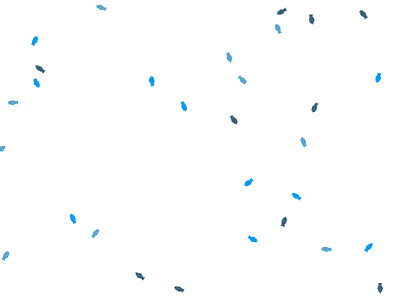

In [365]:
def render(task, algo, policy):

    state_list = []

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        state_list.append(task_s.state[0])
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    state_list.append(task_s.state[0])
    print('reward={}'.format(reward))
    return images, state_list


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs, state_list1 = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

### larger future rewards

In [366]:
seed = 42
neighbor_num = 5

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[60, 60],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-25 06:12:01,407 [INFO] MLPPolicy.num_params = 4681
EvoJAX: 2022-03-25 06:12:01,482 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-25 06:12:03,181 [INFO] Iter=10, size=64, max=-36.0305, avg=-43.4749, min=-52.5915, std=3.8598
EvoJAX: 2022-03-25 06:12:03,698 [INFO] Iter=20, size=64, max=-33.6511, avg=-38.5775, min=-44.6881, std=2.4351
EvoJAX: 2022-03-25 06:12:04,175 [INFO] Iter=30, size=64, max=-33.2717, avg=-38.0736, min=-49.5482, std=3.9560
EvoJAX: 2022-03-25 06:12:05,239 [INFO] [TEST] Iter=30, #tests=10, max=-30.4645 avg=-33.5102, min=-41.8219, std=3.4830
EvoJAX: 2022-03-25 06:12:05,734 [INFO] Iter=40, size=64, max=-32.6695, avg=-35.6453, min=-40.1368, std=1.5279
EvoJAX: 2022-03-25 06:12:06,205 [INFO] Iter=50, size=64, max=-32.3484, avg=-35.4193, min=-40.6308, std=1.7719
EvoJAX: 2022-03-25 06:12:06,699 [INFO] Iter=60, size=64, max=-30.7894, avg=-33.9590, min=-37.8375, std=1.4536
EvoJAX: 2022-03-25 06:12:06,748 [INFO] [TEST] Iter=60, #tests=10, max=-32.7239 av

reward=[-28.013565]


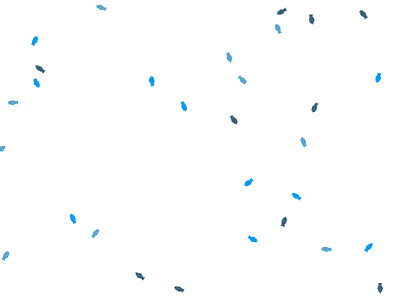

In [367]:
def render(task, algo, policy):

    state_list = []

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        state_list.append(task_s.state[0])
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    state_list.append(task_s.state[0])
    print('reward={}'.format(reward))
    return images, state_list


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs, state_list2 = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking2.gif')
DisplayImage('flocking2.gif', format='png')

It can be seen the larger the future reward, eventually the more equally aligned the fishes become.  

We don't know if changing the reward function caused more collisions or slow alignment.  
So, let's output the angle transitions to a graph.  

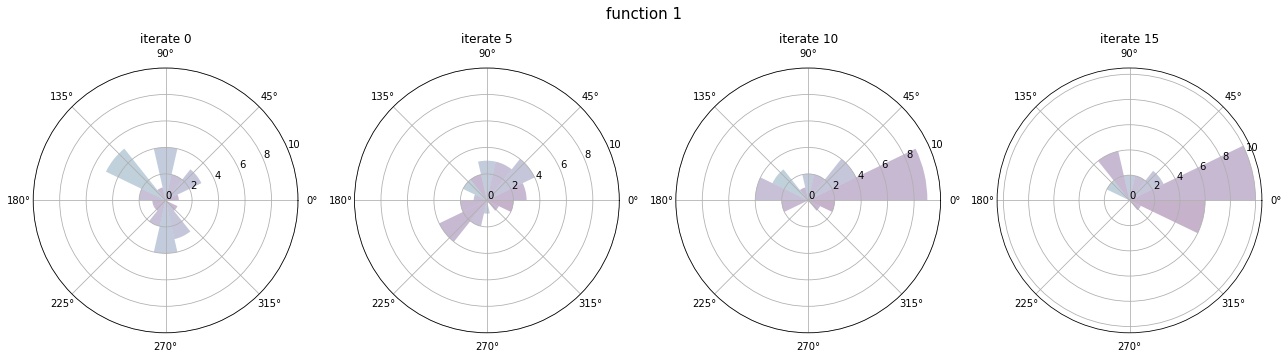

In [429]:
import numpy as np
import matplotlib.pyplot as plt

theta_list1 = []

for i in range(0, 4):
    theta_list1.append(jnp.mod(state_list1[i*5][:, 2], jnp.pi*2))

divi_num = 15
x = np.linspace(0, 2 * np.pi, divi_num)
width = x[1]

count1 = np.zeros(shape=(4, divi_num))

for i in range(0, 4):
    for j in range(0, divi_num-1):
        count1[i][j] = jnp.sum(jnp.where((theta_list1[i]>x[j]) & (theta_list1[i]<x[j+1]), 1, 0))

fig = plt.figure(figsize=(18, 5), tight_layout=True)

x = np.linspace(0, 2 * np.pi, divi_num)
colors = plt.cm.viridis(count1[0] / divi_num)

for i in range(0, 4):
    ax = plt.subplot(1, 4, i+1, projection="polar")
    ax.bar(x, count1[i], width=width, bottom=0.0, color=colors, alpha=0.3, align='edge')
    ax.set_yticks(np.arange(0, 11, 2))
    ax.set_title('iterate ' + str(5*i))

fig.suptitle('function 1', fontsize=15)
plt.savefig('circle_plot1.png')
plt.show()


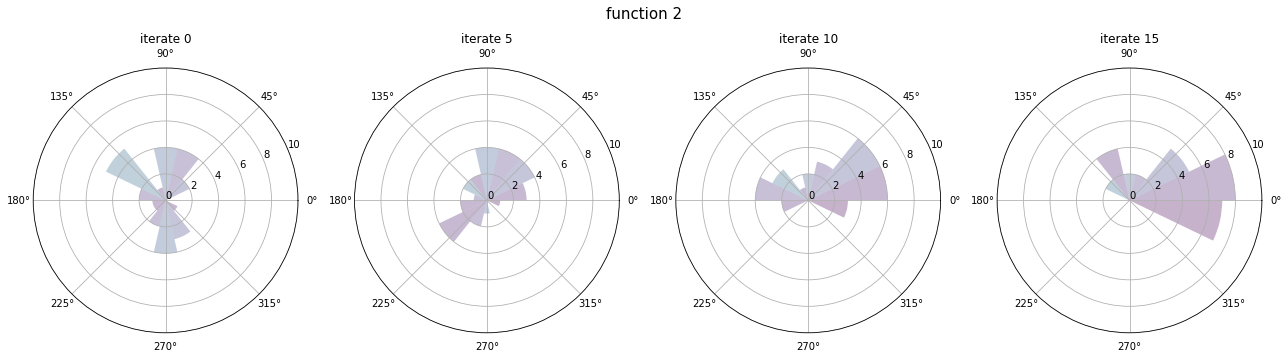

In [430]:
theta_list2 = []

for i in range(0, 4):
    theta_list2.append(jnp.mod(state_list2[i*5][:, 2], jnp.pi*2))

count2 = np.zeros(shape=(4, divi_num))

for i in range(0, 4):
    for j in range(0, divi_num-1):
        count2[i][j] = jnp.sum(jnp.where((theta_list2[i]>x[j]) & (theta_list2[i]<x[j+1]), 1, 0))

fig = plt.figure(figsize=(18, 5), tight_layout=True)

for i in range(0, 4):
    ax = plt.subplot(1, 4, i+1, projection="polar")
    ax.bar(x, count2[i], width=width, bottom=0.0, color=colors, alpha=0.3, align='edge')
    ax.set_yticks(np.arange(0, 11, 2))
    ax.set_title('iterate ' + str(5*i))

fig.suptitle('function 2', fontsize=15)
plt.savefig('circle_plot2.png')
plt.show()


No significant change in Alignment performance was seeb.  
This is probably why there are more initial collisions.

# Change Parameters
Flocking task has many parameters. Let's change some of them.

## Observation
In this task, the fishes observe the states of the nearest 5 fishes in default.  
If they are changed to other values, let's see what happens.

### M = 2

In [ ]:
seed = 42
neighbor_num = 2
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[60, 60],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-24 06:53:23,080 [INFO] MLPPolicy.num_params = 4141
EvoJAX: 2022-03-24 06:53:23,187 [INFO] Start to train for 400 iterations.
EvoJAX: 2022-03-24 06:53:25,542 [INFO] Iter=10, size=64, max=-32.6140, avg=-44.5557, min=-58.7534, std=6.1091
EvoJAX: 2022-03-24 06:53:26,043 [INFO] Iter=20, size=64, max=-31.0509, avg=-34.7228, min=-49.6785, std=3.3636
EvoJAX: 2022-03-24 06:53:26,512 [INFO] Iter=30, size=64, max=-32.1174, avg=-34.5210, min=-43.1201, std=1.8799
EvoJAX: 2022-03-24 06:53:27,687 [INFO] [TEST] Iter=30, #tests=10, max=-29.1514 avg=-32.9790, min=-39.3626, std=3.2010
EvoJAX: 2022-03-24 06:53:28,179 [INFO] Iter=40, size=64, max=-30.1480, avg=-33.2050, min=-43.1819, std=2.1112
EvoJAX: 2022-03-24 06:53:28,641 [INFO] Iter=50, size=64, max=-31.5706, avg=-33.6211, min=-44.1354, std=1.8075
EvoJAX: 2022-03-24 06:53:29,118 [INFO] Iter=60, size=64, max=-30.5696, avg=-33.2053, min=-43.6250, std=1.8918
EvoJAX: 2022-03-24 06:53:29,164 [INFO] [TEST] Iter=60, #tests=10, max=-29.5486 av

reward=[-26.923864]


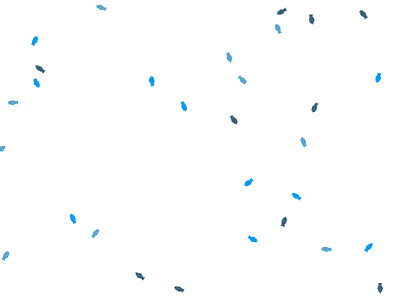

In [29]:
def render(task, algo, policy):

    state_list = []

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        if step % 10 == 0:
            state_list.append(task_s.state[0])
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    state_list.append(task_s.state[0])
    print('reward={}'.format(reward))
    return images, state_list


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs, state_list1 = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

### M = 3

In [26]:
seed = 42
neighbor_num = 3
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[60, 60],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-24 06:48:53,555 [INFO] MLPPolicy.num_params = 4321
EvoJAX: 2022-03-24 06:48:53,645 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-24 06:48:55,292 [INFO] Iter=10, size=64, max=-31.6637, avg=-43.1596, min=-49.7559, std=4.2242
EvoJAX: 2022-03-24 06:48:55,775 [INFO] Iter=20, size=64, max=-32.4137, avg=-35.5087, min=-40.5648, std=2.1785
EvoJAX: 2022-03-24 06:48:56,242 [INFO] Iter=30, size=64, max=-31.6292, avg=-34.9089, min=-39.5635, std=1.6533
EvoJAX: 2022-03-24 06:48:57,264 [INFO] [TEST] Iter=30, #tests=10, max=-28.4677 avg=-32.2879, min=-37.6766, std=3.2378
EvoJAX: 2022-03-24 06:48:57,788 [INFO] Iter=40, size=64, max=-32.0038, avg=-34.5864, min=-39.1915, std=1.4527
EvoJAX: 2022-03-24 06:48:58,255 [INFO] Iter=50, size=64, max=-32.2347, avg=-34.2386, min=-36.7649, std=1.0661
EvoJAX: 2022-03-24 06:48:58,744 [INFO] Iter=60, size=64, max=-31.3793, avg=-33.7652, min=-36.6423, std=1.1863
EvoJAX: 2022-03-24 06:48:58,791 [INFO] [TEST] Iter=60, #tests=10, max=-29.1840 av

reward=[-28.342676]


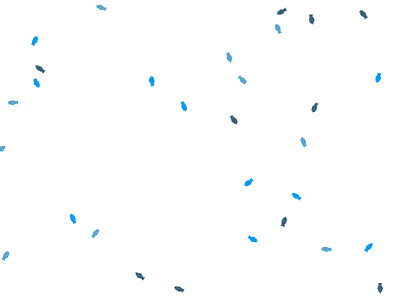

In [27]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

### M=7

In [20]:
seed = 42
neighbor_num = 7
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[60, 60],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-24 06:43:46,574 [INFO] MLPPolicy.num_params = 5041
EvoJAX: 2022-03-24 06:43:46,683 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-24 06:43:49,066 [INFO] Iter=10, size=64, max=-37.7845, avg=-43.7664, min=-50.8572, std=3.4188
EvoJAX: 2022-03-24 06:43:49,567 [INFO] Iter=20, size=64, max=-37.8265, avg=-43.8214, min=-50.2193, std=2.6729
EvoJAX: 2022-03-24 06:43:50,048 [INFO] Iter=30, size=64, max=-36.7882, avg=-42.2710, min=-49.1090, std=2.3647
EvoJAX: 2022-03-24 06:43:51,184 [INFO] [TEST] Iter=30, #tests=10, max=-36.3226 avg=-42.6190, min=-52.6242, std=4.8935
EvoJAX: 2022-03-24 06:43:51,683 [INFO] Iter=40, size=64, max=-37.1243, avg=-42.3443, min=-46.8865, std=2.3204
EvoJAX: 2022-03-24 06:43:52,162 [INFO] Iter=50, size=64, max=-37.3533, avg=-43.6082, min=-50.8633, std=2.7245
EvoJAX: 2022-03-24 06:43:52,663 [INFO] Iter=60, size=64, max=-37.4787, avg=-41.8696, min=-46.4044, std=1.9123
EvoJAX: 2022-03-24 06:43:52,710 [INFO] [TEST] Iter=60, #tests=10, max=-31.2398 av

reward=[-37.76369]


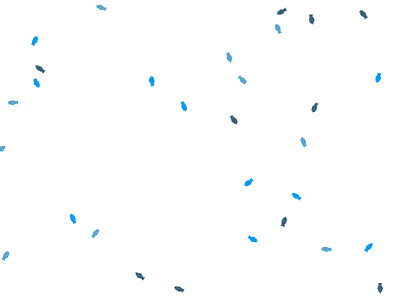

In [25]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

If we set M too large, the learning process will not proceed well.  
It turns out that they behave completely differently depending on the NEIGHBOR_NUM.

## Allowable angle of rotation
If the allowable angle of rotation were increased, collisions might be easier to avoid.
Let's try it.

In [43]:
seed = 42
neighbor_num = 5
evojax.task.flocking.NEIGHBOR_NUM = neighbor_num
evojax.task.flocking.SPEED = 0.04
evojax.task.flocking.DT = 0.6

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[60, 60],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-24 07:45:10,905 [INFO] MLPPolicy.num_params = 4681
EvoJAX: 2022-03-24 07:45:10,978 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-24 07:45:12,665 [INFO] Iter=10, size=64, max=-42.8731, avg=-55.9714, min=-97.3251, std=6.9698
EvoJAX: 2022-03-24 07:45:13,138 [INFO] Iter=20, size=64, max=-41.6806, avg=-58.0717, min=-75.3256, std=7.3027
EvoJAX: 2022-03-24 07:45:13,610 [INFO] Iter=30, size=64, max=-42.9448, avg=-51.1105, min=-91.5215, std=8.9609
EvoJAX: 2022-03-24 07:45:14,632 [INFO] [TEST] Iter=30, #tests=10, max=-39.4625 avg=-46.4609, min=-55.7633, std=4.5620
EvoJAX: 2022-03-24 07:45:15,128 [INFO] Iter=40, size=64, max=-36.9459, avg=-47.4601, min=-119.0514, std=11.5744
EvoJAX: 2022-03-24 07:45:15,600 [INFO] Iter=50, size=64, max=-41.2773, avg=-47.6441, min=-64.9019, std=3.7334
EvoJAX: 2022-03-24 07:45:16,091 [INFO] Iter=60, size=64, max=-47.9811, avg=-53.4735, min=-65.0613, std=3.3242
EvoJAX: 2022-03-24 07:45:16,141 [INFO] [TEST] Iter=60, #tests=10, max=-41.0633 

reward=[-40.561817]


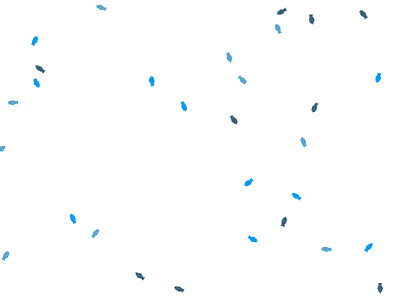

In [44]:
def render(task, algo, policy):

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

Unintentionally, they have learned to rotate on the spot.  
It is true that rotating in place like other fish satisfies Alignment and Avoidance....